Importing basic packages and loading in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# training data
trainingdata = pd.read_csv('augroadtrips_example.csv', index_col = 0)

# testing data, using a different month to remove redudancies in the games used to generate the games
testingdata = pd.read_csv('julyroadtrips_example.csv', index_col = 0)

Import regressions that we will use, and build scalers

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

Build x and y data (1 for low price, 2 for median price)

In [3]:
trainingx = trainingdata.drop(['lowprice', 'medprice', 'indices'], axis = 1)
trainingy1 = trainingdata.lowprice
trainingy2 = trainingdata.medprice

testingx = testingdata.drop(['lowprice', 'medprice', 'indices'], axis = 1)
testingy1 = testingdata.lowprice
testingy2 = testingdata.medprice

# making sure the columns are in the same order
testingx = testingx[trainingx.columns]

The cell below emphasizes the importance of having a training data set completely separate from the testing set.

In [4]:

# we're going to build simple linear models here
linlowprice = LinearRegression()
linmedprice = LinearRegression()

# fit them to the training data
linlowprice.fit(trainingx, trainingy1)
linmedprice.fit(trainingx, trainingy2)

# calculate cross validation scores
lowpricecv = cross_val_score(LinearRegression(), trainingx, trainingy1, cv = KFold(shuffle = True, 
                                                                                   n_splits = 5, random_state = 42))

medpricecv = cross_val_score(LinearRegression(), trainingx, trainingy2, cv = KFold(shuffle = True,
                                                                                 n_splits = 5, random_state = 42))


# print the accuracies and attempts at cross validation
print('Accuracy of low price  on training set: ' + str(linlowprice.score(trainingx, trainingy1)))
print('Cross Validation mean :' + str(np.mean(lowpricecv)) + ' standard deviation: ' + str(np.std(lowpricecv)))
print('Accuracy of low price  on testing set: ' + str(linlowprice.score(testingx, testingy1)))

print('')

print('Accuracy of median price  on training set: ' + str(linmedprice.score(trainingx, trainingy2)))
print('Cross Validation mean :' + str(np.mean(medpricecv)) + ' standard deviation: ' + str(np.std(medpricecv)))
print('Accuracy of median price  on testing set: ' + str(linmedprice.score(testingx, testingy2)))


Accuracy of low price  on training set: 0.8355470293016961
Cross Validation mean :0.8352717212910898 standard deviation: 0.0019267671896989152
Accuracy of low price  on testing set: 0.6359970138665918

Accuracy of median price  on training set: 0.9392642092580737
Cross Validation mean :0.9391631327246174 standard deviation: 0.0005456264239702517
Accuracy of median price  on testing set: 0.655182866780063


Notably, cross validation essentially reproduces the fit on the entire dataset with minimal standard deviation. Now we'll do some feature engineering by dropping features which shouldn't affect the price of the tickets

In [5]:
trainingx2 = trainingx.drop(['total_days', 'total_miles', 'min_temp', 'max_temp'], axis = 1)
testingx2 = testingx.drop(['total_days', 'total_miles', 'min_temp', 'max_temp'], axis = 1)

Some of these features don't make the most sense, instead of affecting things on a per game basis, they affect them on aggregate. So let's fix this. We also need to subtract out the mean values, otherwise this scaling just makes these variables a reflection of the number of games. The mean needs to be the same between the testing and training sets as well.

In [6]:
# copying the data
trainingx3 = trainingx2.copy()
testingx3 = testingx2.copy()

# we're going to subtract away from the mean and then scale for games
# we're using the same mean, as otherwise the data will be scaled differently

# first the testing data
testingx3.percent_day_games = (testingx3.percent_day_games - trainingx3.percent_day_games.mean()) * testingx3.total_games
testingx3.percent_weekends = (testingx3.percent_weekends - trainingx3.percent_weekends.mean()) * testingx3.total_games
testingx3.game_quality_h= (testingx3.game_quality_h - trainingx3.game_quality_h.mean()) * testingx3.total_games
testingx3.game_quality_a = (testingx3.game_quality_a - trainingx3.game_quality_a.mean()) * testingx3.total_games
testingx3.game_importance_h = (testingx3.game_importance_h - trainingx3.game_importance_h.mean()) * testingx3.total_games
testingx3.game_importance_a = (testingx3.game_importance_a - trainingx3.game_importance_a .mean()) * testingx3.total_games
testingx3.avg_temp = (testingx3.avg_temp - trainingx3.avg_temp.mean()) * testingx3.total_games

# now for the training data
trainingx3.percent_day_games = (trainingx3.percent_day_games - trainingx3.percent_day_games.mean()) * trainingx3.total_games
trainingx3.percent_weekends = (trainingx3.percent_weekends - trainingx3.percent_weekends.mean()) * trainingx3.total_games
trainingx3.game_quality_h= (trainingx3.game_quality_h - trainingx3.game_quality_h.mean()) * trainingx3.total_games
trainingx3.game_quality_a = (trainingx3.game_quality_a - trainingx3.game_quality_a.mean()) * trainingx3.total_games
trainingx3.game_importance_h = (trainingx3.game_importance_h - trainingx3.game_importance_h.mean()) * trainingx3.total_games
trainingx3.game_importance_a = (trainingx3.game_importance_a - trainingx3.game_importance_a.mean()) * trainingx3.total_games
trainingx3.avg_temp = (trainingx3.avg_temp - trainingx3.avg_temp.mean()) * trainingx3.total_games

Now we'll define a function that'll help us test the possible fits

In [7]:
# takes in training and testing (b) data, and an alpha for regularization and performs a series of fits
def ManyFits(x, xb, y1, y2, yb1, yb2, a):
    # build scalers for the data
    s1 = StandardScaler()
    s2 = StandardScaler()
    s1.fit(x)
    s2.fit(xb)
    
    # create linear fits
    linlowprice = LinearRegression()
    linmedprice = LinearRegression()
    linlowprice.fit(s1.transform(x), y1)
    linmedprice.fit(s1.transform(x), y2)
    
    linlowpriceb = LinearRegression()
    linmedpriceb = LinearRegression()
    linlowpriceb.fit(s2.transform(xb), yb1)
    linmedpriceb.fit(s2.transform(xb), yb2)

    # create lasso regressions with alpha a
    lassolowprice = Lasso(alpha = a)
    lassomedprice = Lasso(alpha = a)
    lassolowprice.fit(s1.transform(x), y1)
    lassomedprice.fit(s1.transform(x), y2)

    lassolowpriceb = Lasso(alpha = a)
    lassomedpriceb = Lasso(alpha = a)
    lassolowpriceb.fit(s2.transform(xb), yb1)
    lassomedpriceb.fit(s2.transform(xb), yb2)

    # create ridge regressions
    ridlowprice = Ridge(alpha = a)
    ridmedprice = Ridge(alpha = a)
    ridlowprice.fit(s1.transform(x), y1)
    ridmedprice.fit(s1.transform(x), y2)

    ridlowpriceb = Ridge(alpha = a)
    ridmedpriceb = Ridge(alpha = a)
    ridlowpriceb.fit(s2.transform(xb), yb1)
    ridmedpriceb.fit(s2.transform(xb), yb2)
    
    # print out the accuracies
    
    print('Linear model on low price:')
    print('Accuracy for model fit on training data on testing data: ' 
          + str(linlowprice.score(s1.transform(xb), yb1)))
    print('Accuracy for model fit on testing data on training data: ' 
          + str(linlowpriceb.score(s2.transform(x), y1)))
    print('Linear model on median price:')
    print('Accuracy for model fit on training data on testing data: ' 
          + str(linmedprice.score(s1.transform(xb),yb2)))
    print('Accuracy for model fit on testing data on training data: ' 
          + str(linmedpriceb.score(s2.transform(x),y2)))
    print('')
    
    print('Lasso model on low price')
    print('Accuracy for model fit on training data on testing data: ' 
          + str(lassolowprice.score(s1.transform(xb), yb1)))
    print('Accuracy for model fit on testing data on training data: ' 
          + str(lassolowpriceb.score(s2.transform(x), y1)))
    print('Lasso model on median price')
    print('Accuracy for model fit on training data on testing data: ' 
          + str(lassomedprice.score(s1.transform(xb), yb2)))
    print('Accuracy for model fit on testing data on training data: ' 
          + str(lassomedpriceb.score(s2.transform(x), y2)))
    print('')
    
    print('Ridge model on low price:')
    print('Accuracy for model fit on training data on testing data: ' 
          + str(ridlowprice.score(s1.transform(xb), yb1)))
    print('Accuracy for model fit on testing data on training data: ' 
          + str(ridlowpriceb.score(s2.transform(x), y1)))
    print('Ridge model on median price:')
    print('Accuracy for model fit on training data on testing data: ' 
          + str(ridmedprice.score(s1.transform(xb), yb2)))
    print('Accuracy for model fit on testing data on training data: ' 
          + str(ridmedpriceb.score(s2.transform(x), y2)))

Before removing features

In [8]:
ManyFits(trainingx, testingx, trainingy1, trainingy2, testingy1, testingy2, 1)

Linear model on low price:
Accuracy for model fit on training data on testing data: 0.6277683766662696
Accuracy for model fit on testing data on training data: 0.5167633668721845
Linear model on median price:
Accuracy for model fit on training data on testing data: 0.6450931769429015
Accuracy for model fit on testing data on training data: 0.6812753036039586

Lasso model on low price
Accuracy for model fit on training data on testing data: 0.5363062527076199
Accuracy for model fit on testing data on training data: 0.5111488560954971
Lasso model on median price
Accuracy for model fit on training data on testing data: 0.6258213530538315
Accuracy for model fit on testing data on training data: 0.7189537061561926

Ridge model on low price:
Accuracy for model fit on training data on testing data: 0.6359986582502938
Accuracy for model fit on testing data on training data: 0.5362740083246504
Ridge model on median price:
Accuracy for model fit on training data on testing data: 0.65519708429521

After removing features:

In [9]:
ManyFits(trainingx2, testingx2, trainingy1, trainingy2, testingy1, testingy2, 1)

Linear model on low price:
Accuracy for model fit on training data on testing data: 0.6329202139573806
Accuracy for model fit on testing data on training data: 0.6013156997778883
Linear model on median price:
Accuracy for model fit on training data on testing data: 0.6492260474798809
Accuracy for model fit on testing data on training data: 0.7509289637246548

Lasso model on low price
Accuracy for model fit on training data on testing data: 0.5354283520105383
Accuracy for model fit on testing data on training data: 0.5137560792383533
Lasso model on median price
Accuracy for model fit on training data on testing data: 0.6237681524641941
Accuracy for model fit on testing data on training data: 0.7078723438521437

Ridge model on low price:
Accuracy for model fit on training data on testing data: 0.6329439763732048
Accuracy for model fit on testing data on training data: 0.6000322955040255
Ridge model on median price:
Accuracy for model fit on training data on testing data: 0.64923496326737

There does indeed appear to be some improvement. And now with the smarter features:

In [10]:
ManyFits(trainingx3, testingx3, trainingy1, trainingy2, testingy1, testingy2, 1)

Linear model on low price:
Accuracy for model fit on training data on testing data: 0.6572664772137382
Accuracy for model fit on testing data on training data: 0.6410713227481388
Linear model on median price:
Accuracy for model fit on training data on testing data: 0.6683992411598233
Accuracy for model fit on testing data on training data: 0.7737934555597432

Lasso model on low price
Accuracy for model fit on training data on testing data: 0.5761370525060174
Accuracy for model fit on testing data on training data: 0.5181617858366027
Lasso model on median price
Accuracy for model fit on training data on testing data: 0.6425425002404959
Accuracy for model fit on testing data on training data: 0.7152639360221071

Ridge model on low price:
Accuracy for model fit on training data on testing data: 0.6684064286949956
Accuracy for model fit on testing data on training data: 0.6413685744021388
Ridge model on median price:
Accuracy for model fit on training data on testing data: 0.67221563591994

Even better! Now we're quickly going to evaluate a few alpha values

In [11]:
ManyFits(trainingx3, testingx3, trainingy1, trainingy2, testingy1, testingy2, .25)

Linear model on low price:
Accuracy for model fit on training data on testing data: 0.6572664772137382
Accuracy for model fit on testing data on training data: 0.6410713227481388
Linear model on median price:
Accuracy for model fit on training data on testing data: 0.6683992411598233
Accuracy for model fit on testing data on training data: 0.7737934555597432

Lasso model on low price
Accuracy for model fit on training data on testing data: 0.6576579451350053
Accuracy for model fit on testing data on training data: 0.5624030631868802
Lasso model on median price
Accuracy for model fit on training data on testing data: 0.6722734526794646
Accuracy for model fit on testing data on training data: 0.7536744336501372

Ridge model on low price:
Accuracy for model fit on training data on testing data: 0.6684038621320714
Accuracy for model fit on testing data on training data: 0.6413859717849554
Ridge model on median price:
Accuracy for model fit on training data on testing data: 0.67221130482876

In [12]:
ManyFits(trainingx3, testingx3, trainingy1, trainingy2, testingy1, testingy2, 1)

Linear model on low price:
Accuracy for model fit on training data on testing data: 0.6572664772137382
Accuracy for model fit on testing data on training data: 0.6410713227481388
Linear model on median price:
Accuracy for model fit on training data on testing data: 0.6683992411598233
Accuracy for model fit on testing data on training data: 0.7737934555597432

Lasso model on low price
Accuracy for model fit on training data on testing data: 0.5761370525060174
Accuracy for model fit on testing data on training data: 0.5181617858366027
Lasso model on median price
Accuracy for model fit on training data on testing data: 0.6425425002404959
Accuracy for model fit on testing data on training data: 0.7152639360221071

Ridge model on low price:
Accuracy for model fit on training data on testing data: 0.6684064286949956
Accuracy for model fit on testing data on training data: 0.6413685744021388
Ridge model on median price:
Accuracy for model fit on training data on testing data: 0.67221563591994

In [13]:
ManyFits(trainingx3, testingx3, trainingy1, trainingy2, testingy1, testingy2, 5)

Linear model on low price:
Accuracy for model fit on training data on testing data: 0.6572664772137382
Accuracy for model fit on testing data on training data: 0.6410713227481388
Linear model on median price:
Accuracy for model fit on training data on testing data: 0.6683992411598233
Accuracy for model fit on testing data on training data: 0.7737934555597432

Lasso model on low price
Accuracy for model fit on training data on testing data: 0.3224376381640508
Accuracy for model fit on testing data on training data: 0.50668278690326
Lasso model on median price
Accuracy for model fit on training data on testing data: 0.5422285355573824
Accuracy for model fit on testing data on training data: 0.7163546931970217

Ridge model on low price:
Accuracy for model fit on training data on testing data: 0.6684197506438012
Accuracy for model fit on testing data on training data: 0.6412758680993911
Ridge model on median price:
Accuracy for model fit on training data on testing data: 0.6722384404460577

In [14]:
ManyFits(trainingx3, testingx3, trainingy1, trainingy2, testingy1, testingy2, 10)

Linear model on low price:
Accuracy for model fit on training data on testing data: 0.6572664772137382
Accuracy for model fit on testing data on training data: 0.6410713227481388
Linear model on median price:
Accuracy for model fit on training data on testing data: 0.6683992411598233
Accuracy for model fit on testing data on training data: 0.7737934555597432

Lasso model on low price
Accuracy for model fit on training data on testing data: 0.28543938432937843
Accuracy for model fit on testing data on training data: 0.44147508616593034
Lasso model on median price
Accuracy for model fit on training data on testing data: 0.48701986095559985
Accuracy for model fit on testing data on training data: 0.7118855972946116

Ridge model on low price:
Accuracy for model fit on training data on testing data: 0.6684355434287717
Accuracy for model fit on testing data on training data: 0.6411601749578546
Ridge model on median price:
Accuracy for model fit on training data on testing data: 0.67226625493

They don't have a huge effect so we're going to keep using an alpha of 1. Now, we're finally going to make the model and do a brief evaluation of its efficacy.

In [15]:
# create a scaler for the data
trainingscaler = StandardScaler()
trainingscaler.fit(trainingx3)

# actually scale the data
trainingt = trainingscaler.transform(trainingx3)
testingt = trainingscaler.transform(testingx3)

# create fits
lowpricemodel = Ridge()
medpricemodel = Ridge()
lowpricemodel.fit(trainingt, trainingy1)
medpricemodel.fit(trainingt, trainingy2)



Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Let's do a histogram of the residuals for the low price data

Difference between average price between testing and training data: 10.682323002618602
Mean of the residuals for the testing data: 11.877254704750682


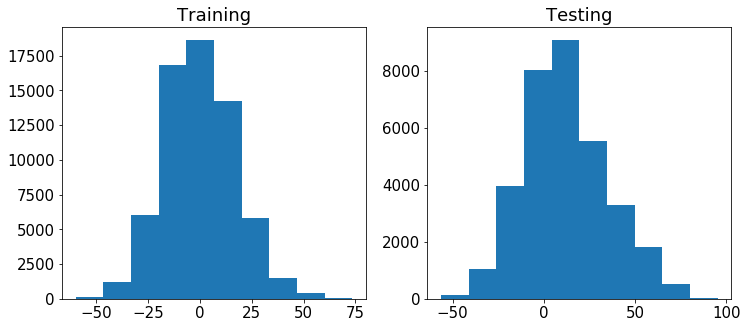

In [16]:
# initialize figure
plt.figure(figsize = (12, 5))
plt.rcParams.update({'font.size' : 15})

# plot histogram for training data
plt.subplot(1, 2, 1)
plt.hist(trainingy1 - lowpricemodel.predict(trainingt))
plt.title('Training')

# plot histogram for testing data
plt.subplot(1, 2, 2)
plt.hist(testingy1 - lowpricemodel.predict(testingt))
plt.title('Testing')

# print out some general stats
print('Difference between average price between testing and training data: ' + str(np.mean(testingy1) - np.mean(trainingy1)))
print('Mean of the residuals for the testing data: ' + str(np.mean(testingy1 - lowpricemodel.predict(testingt))))

The residuals seem mostly normally distributed with a shift in the testing data roughly equal to the differences in the average prices. Let's repeat it for the median priced data.

Difference between average price between testing and training data: 19.431665136628055
Mean of the residuals for the testing data: 40.97310895596243


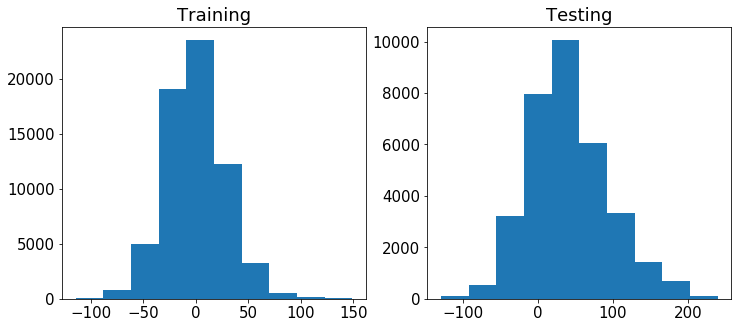

In [17]:
# initialize figure
plt.figure(figsize = (12, 5))
plt.rcParams.update({'font.size' : 15})

# plot histogram for training data
plt.subplot(1, 2, 1)
plt.title('Training')
plt.hist(trainingy2 - medpricemodel.predict(trainingt))

# plot histogram for testing data
plt.subplot(1, 2, 2)
plt.hist(testingy2 - medpricemodel.predict(testingt))
plt.title('Testing')

# print out some general stats
print('Difference between average price between testing and training data: ' + str(np.mean(testingy2) - np.mean(trainingy2)))
print('Mean of the residuals for the testing data: ' + str(np.mean(testingy2 - medpricemodel.predict(testingt))))

Again, fairly reasonable, although the shift is a bit higher here. Let's see how it depends on the individual inputs (minus location data).

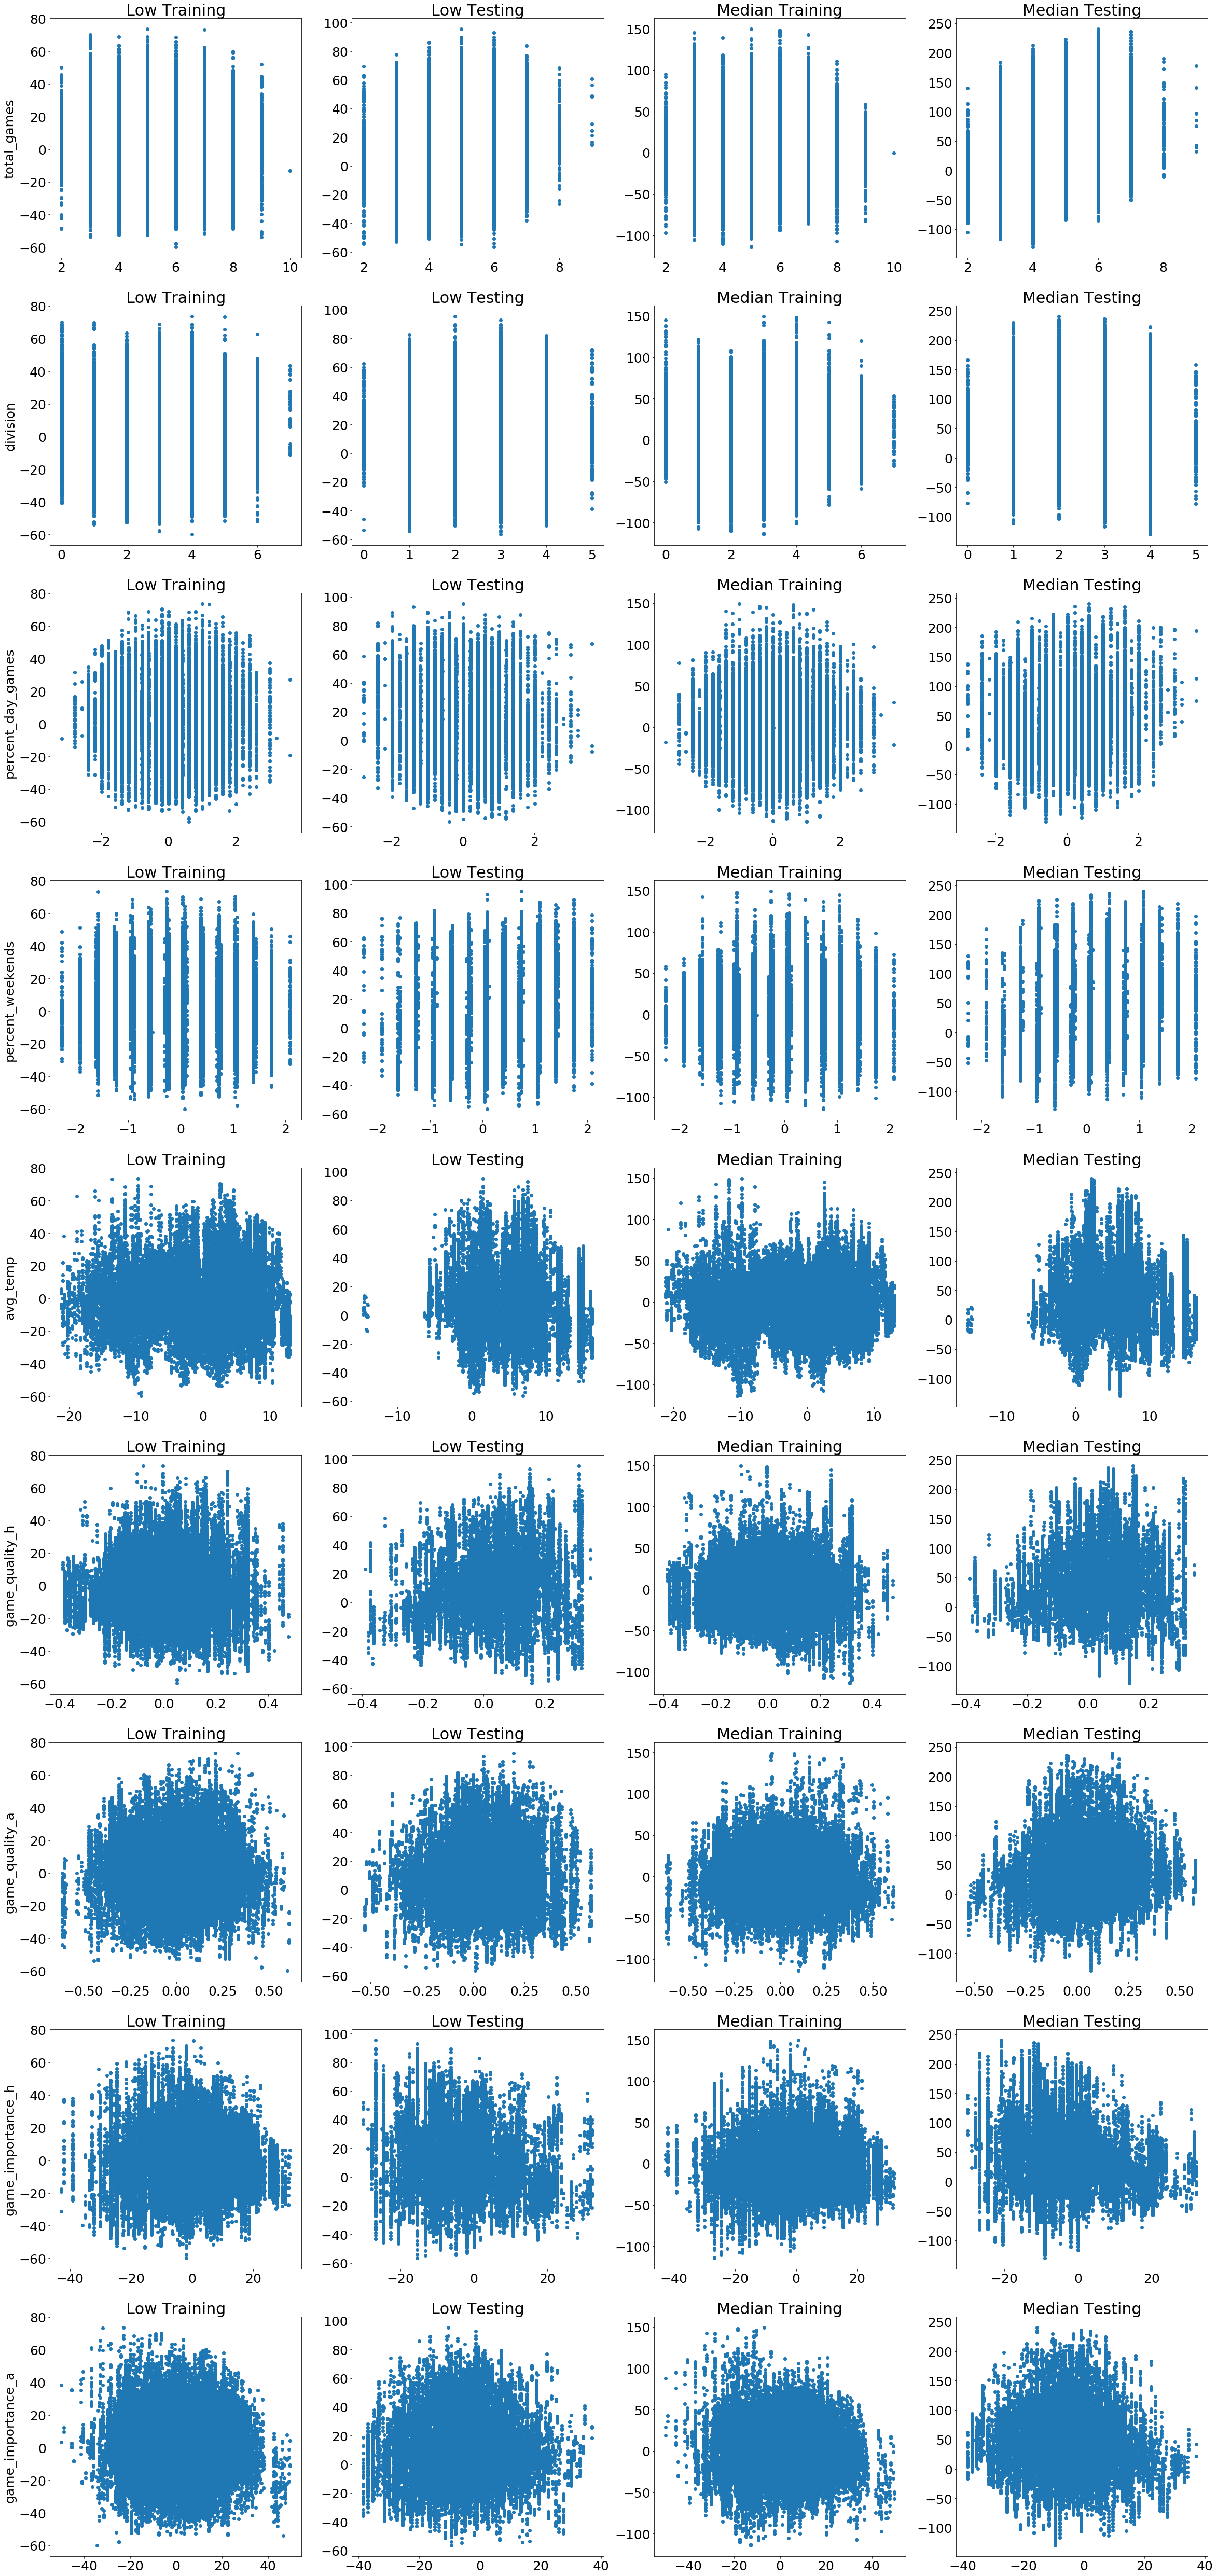

In [18]:
# intialize everything
plt.figure(figsize = (40, 90))
plt.rcParams.update({'font.size' : 25})

# make all the plots
for i in range(9):
        plt.subplot(9, 4, 1 + i * 4)
        plt.ylabel(trainingx3.columns[i])
        plt.title('Low Training')
        plt.scatter(trainingx3.iloc[:,i], trainingy1 - lowpricemodel.predict(trainingscaler.transform(trainingx3)))
        
        plt.subplot(9, 4, 2 + i * 4)
        plt.title('Low Testing')
        plt.scatter(testingx3.iloc[:,i], testingy1 - lowpricemodel.predict(trainingscaler.transform(testingx3)))
        
        plt.subplot(9, 4, 3 + i * 4)
        plt.title('Median Training')
        plt.scatter(trainingx3.iloc[:,i], trainingy2 - medpricemodel.predict(trainingscaler.transform(trainingx3)))
        
        plt.subplot(9, 4, 4 + i * 4)
        plt.title('Median Testing')
        plt.scatter(testingx3.iloc[:,i], testingy2 - medpricemodel.predict(trainingscaler.transform(testingx3)))

Again, not too bad, finally, let's see how the various variables affect the price. First we'll generate those arrays.

In [19]:
low_day_game_effects = trainingt[:, 2] * lowpricemodel.coef_[2]
low_game_quality_effects = np.sum(trainingt[:, [1, 5, 6, 7, 8]] * lowpricemodel.coef_[[1, 5, 6, 7, 8]], axis = 1)
low_location_effects = np.sum(trainingt[:, 9:] * lowpricemodel.coef_[9:], axis = 1)
low_weather_effects = trainingt[:, 4] *lowpricemodel.coef_[4]

med_day_game_effects = trainingt[:, 2] * medpricemodel.coef_[2]
med_game_quality_effects = np.sum(trainingt[:, [1, 5, 6, 7, 8]] * medpricemodel.coef_[[1, 5, 6, 7, 8]], axis = 1)
med_location_effects = np.sum(trainingt[:, 9:] * medpricemodel.coef_[9:], axis = 1)
med_weather_effects = trainingt[:, 4] * medpricemodel.coef_[4]

For comparisons, I think it's a little bit nicer to use a kernel density estimation plot. We need to plot the day games factor on a separate plot because it's so much smaller. First for the low price data:

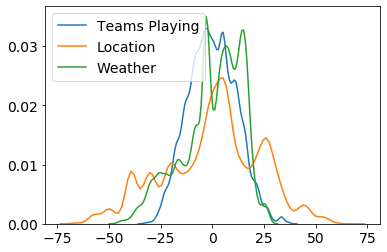

In [21]:
import seaborn as sns
plt.rcParams.update({'font.size' : 14})
sns.kdeplot(low_game_quality_effects, label = 'Teams Playing')
sns.kdeplot(low_location_effects, label = 'Location')
sns.kdeplot(low_weather_effects, label = 'Weather')


Text(0.5, 1.0, 'Day Games')

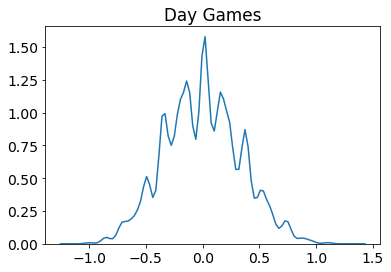

In [22]:
sns.kdeplot(low_day_game_effects)
plt.title('Day Games')

The distributions are actually fairly similar except for the effect of day games.

Now for median prices.

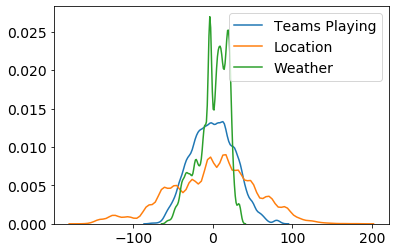

In [23]:
plt.rcParams.update({'font.size' : 14})
sns.kdeplot(med_game_quality_effects, label = 'Teams Playing')
sns.kdeplot(med_location_effects, label = 'Location')
sns.kdeplot(med_weather_effects, label = 'Weather')

Text(0.5, 1.0, 'Day Games')

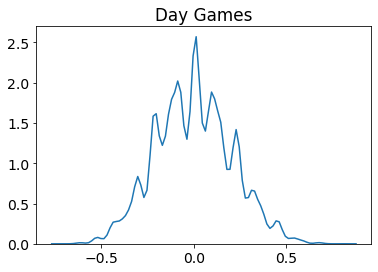

In [24]:
sns.kdeplot(med_day_game_effects)
plt.title('Day Games')

Generally similar with slightly more variation due to the teams playing and even more in the location.